## Reproduce Supp. Fig. 3
Example hierarchical clustering of COX3 family enzymes from the homstrad expert labelled dataset (see Methods of Alley et al. 2019). Note this is a RAM intensive notebook but runs on a 16G laptop.

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import scipy.cluster.hierarchy as hier
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import random
import os
import Levenshtein
import fastcluster as fc
# To allow imports from common directory
sys.path.append('../../')
from common.plot_style_utils import set_pub_plot_context, rep_names, save_for_pub
from common.embedding_tools import lev_dist_matrix, lev_sim_matrix

%matplotlib inline
random.seed(42)
np.random.seed(42)

In [2]:
phens_to_cluster = ['COX1', 'COX2', 'COX3']

In [3]:
# All of the homstrad sequences, reps and baselines
homstrad = pd.read_pickle("../../data/homstrad_w_baseline.pkl")
homstrad

,sequence,phenotype,is_train,is_test,phenotype_name,dataset,RGN,64_avg_hidden,64_final_hidden,64_final_cell,...,all_avg_hidden,all_final_cell,RGN_avg_hidden,RGN_final_cell,simple_freq_plus,simple_freq_and_len,2grams,3grams,tfidf_2grams,tfidf_3grams
20668,TKIVKVTGDYALLEFKDDLTGKGSICAETTAILKYLSEKGIKTHLV...,SAICAR_synt,True,True,family_name,homstrad,"[-0.025834012776613232, -0.05399760976433755, ...","[-0.11867085099220274, 0.11209627985954283, -0...","[-0.11023015528917313, 0.061099682003259666, -...","[-0.16718728840351105, 0.4113061130046845, -0....",...,"[-0.11867085099220274, 0.11209627985954283, -0...","[-0.16718728840351105, 0.4113061130046845, -0....","[-0.025834012776613232, -0.05399760976433755, ...","[-0.025834012776613232, -0.05399760976433755, ...","[0.05263157894736842, 0.014354066985645933, 0....","[0.05263157894736842, 0.014354066985645933, 0....","[1, 0, 0, 3, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.04026548332025606, 0.0, 0.0, 0.126771468660...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20669,SITKTELDGILPLVARGKVRDIYEVDAGTLLFVATDRISAYDVIME...,SAICAR_synt,True,True,family_name,homstrad,"[0.13893805444240567, -0.00019246361625846478,...","[-0.0845603421330452, 0.1088557317852974, -0.1...","[-0.048800613731145866, 0.09936266392469406, -...","[-0.08486960828304291, 0.5393546223640442, -0....",...,"[-0.0845603421330452, 0.1088557317852974, -0.1...","[-0.08486960828304291, 0.5393546223640442, -0....","[0.13893805444240567, -0.00019246361625846478,...","[0.13893805444240567, -0.00019246361625846478,...","[0.06040268456375839, 0.003355704697986577, 0....","[0.06040268456375839, 0.003355704697986577, 0....","[1, 0, 1, 2, 0, 1, 0, 0, 3, 0, 0, 1, 1, 1, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.03242841044691856, 0.0, 0.03571512882338177...","[0.0, 0.0, 0.0, 0.04342385073884401, 0.0, 0.0,..."
20670,GVTVTSHREYLTQVNNSSGFVVNGGIVGNSLQLNPSNGTLFSWLPA...,bv,True,True,family_name,homstrad,"[-0.2107011675834656, 0.02743645198643208, -0....","[0.0143950954079628, 0.14230819046497345, -0.1...","[0.06821956485509872, 0.18811896443367004, -0....","[0.13774429261684418, 0.8134044408798218, -0.1...",...,"[0.0143950954079628, 0.14230819046497345, -0.1...","[0.13774429261684418, 0.8134044408798218, -0.1...","[-0.2107011675834656, 0.02743645198643208, -0....","[-0.2107011675834656, 0.02743645198643208, -0....","[0.08139534883720931, 0.011627906976744186, 0....","[0.08139534883720931, 0.011627906976744186, 0....","[0, 0, 2, 1, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.10974000969089705, 0.052284840727...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20671,SSMDVTILSHCELSTELAVTVTIVVTSELVMPFTVGTWLRGVAQNW...,bv,True,True,family_name,homstrad,"[-0.1806732267141342, 0.039818041026592255, -0...","[0.011167618446052073, 0.1276816874742508, -0....","[0.102280355989933, 0.08621235936880113, -0.15...","[0.1770242303609848, 0.5491780638694763, -0.18...",...,"[0.011167618446052073, 0.1276816874742508, -0....","[0.1770242303609848, 0.5491780638694763, -0.18...","[-0.1806732267141342, 0.039818041026592255, -0...","[-0.1806732267141342, 0.039818041026592255, -0...","[0.09547738693467336, 0.020100502512562814, 0....","[0.09547738693467336, 0.020100502512562814, 0....","[2, 0, 1, 0, 0, 0, 0, 3, 0, 2, 1, 1, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.08210906485157748, 0.0, 0.04521553459337313...","[0.04794958851519534, 0.0, 0.0, 0.0, 0.0, 0.0,..."
20672,GAITVLHCELTAEIGVTDSIVVSSELVMPYTVGTWLRGVADNWSKY...,bv,True,True,family_name,homstrad,"[-0.1597319394350052, 0.06173299625515938, -0....","[0.0020451024174690247, 0.1371651589870453, -0...","[0.11017193645238876, 0.1414894163608551, -0.1...","[0.1897858828306198, 0.6649361252784729, -0.17...",...,"[0.0020451024174690247, 0.1371651589870453, -0...","[0.1897858828306198, 0.6649361252784729, -0.17...","[-0.1597319394350052, 0.06173299625515

In [4]:
to_cluster = homstrad[homstrad.phenotype.isin(phens_to_cluster)]
display(to_cluster.phenotype.unique())
to_cluster

array(['COX2', 'COX1', 'COX3'], dtype=object)

,sequence,phenotype,is_train,is_test,phenotype_name,dataset,RGN,64_avg_hidden,64_final_hidden,64_final_cell,...,all_avg_hidden,all_final_cell,RGN_avg_hidden,RGN_final_cell,simple_freq_plus,simple_freq_and_len,2grams,3grams,tfidf_2grams,tfidf_3grams
22737,MAYPMQLGFQDATSPIMEELLHFHDHTLMIVFLISSLVLYIISLML...,COX2,True,True,family_name,homstrad,"[-0.04553695023059845, -0.04388829320669174, -...","[-0.003500044345855713, 0.12335183471441268, -...","[0.021189255639910698, 0.10715793818235396, -0...","[0.06196942180395126, 0.5150864124298096, -0.1...",...,"[-0.003500044345855713, 0.12335183471441268, -...","[0.06196942180395126, 0.5150864124298096, -0.1...","[-0.04553695023059845, -0.04388829320669174, -...","[-0.04553695023059845, -0.04388829320669174, -...","[0.03524229074889868, 0.00881057268722467, 0.0...","[0.03524229074889868, 0.00881057268722467, 0.0...","[0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08010330...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22738,QDVLGDLPVIGKPVNGGMNFQPASSPLAHDQQWLDHFVLYIITAVT...,COX2,True,True,family_name,homstrad,"[-0.09036321938037872, 0.005319222342222929, -...","[-0.010912010446190834, 0.1338624358177185, -0...","[0.011211555451154707, 0.11658499389886855, -0...","[0.01720476523041725, 1.012166142463684, -0.15...",...,"[-0.010912010446190834, 0.1338624358177185, -0...","[0.01720476523041725, 1.012166142463684, -0.15...","[-0.09036321938037872, 0.005319222342222929, -...","[-0.09036321938037872, 0.005319222342222929, -...","[0.10714285714285714, 0.015873015873015872, 0....","[0.10714285714285714, 0.015873015873015872, 0....","[1, 0, 1, 0, 3, 2, 1, 2, 1, 2, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.035059242790543364, 0.0, 0.0386126040548329...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22739,KPITIEVVSMDWKWFFIYPEQGIATVNEIAFPANTPVYFKVTSNSV...,COX2,True,True,family_name,homstrad,"[-0.11228245496749877, 0.009906998835504057, -...","[-0.07396271824836731, 0.0964210256934166, -0....","[-0.16175825893878934, 0.04987530037760735, -0...","[-0.2651615738868713, 0.5982925891876221, -0.4...",...,"[-0.07396271824836731, 0.0964210256934166, -0....","[-0.2651615738868713, 0.5982925891876221, -0.4...","[-0.11228245496749877, 0.009906998835504057, -...","[-0.11228245496749877, 0.009906998835504057, -...","[0.11392405063291139, 0.012658227848101266, 0....","[0.11392405063291139, 0.012658227848101266, 0....","[3, 0, 1, 1, 3, 1, 0, 1, 2, 0, 1, 2, 1, 0, 0, ...","[0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.14471419401012403, 0.0, 0.05312713975608556...","[0.0, 0.0, 0.0, 0.0, 0.13392415954979697, 0.0,..."
23065,MFINRWLFSTNHKDIGTLYLLFGAWAGMVGTALSLLIRAELGQPGT...,COX1,True,True,family_name,homstrad,"[-0.012137468904256819, -0.008628268726170063,...","[-0.028953758999705318, 0.17900560796260834, 0...","[-0.0448828749358654, 0.0839475467801094, -0.1...","[-0.08655156195163727, 0.6426935195922852, -0....",...,"[-0.028953758999705318, 0.17900560796260834, 0...","[-0.08655156195163727, 0.6426935195922852, -0....","[-0.012137468904256819, -0.008628268726170063,...","[-0.012137468904256819, -0.008628268726170063,...","[0.07782101167315175, 0.0019455252918287938, 0...","[0.07782101167315175, 0.0019455252918287938, 0...","[1, 0, 0, 1, 3, 8, 4, 4, 1, 2, 3, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.01819262609642324, 0.0, 0.0, 0.019092497584...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.027770024424154823..."
23066,GFFTRWFMSTNHKDIGILYLFTAGIVGLISVCFTVYMRMELQHPGV...,COX1,True,True,family_name,homstrad,"[0.029049606993794438, 0.05615921691060065, 0....","[-0.03368571028113365, 0.1744491308927536, 0.2...","[-0.002701762830838561, 0.0639401450753212, -0...","[-0.003754440229386091, 0.3386618494987488, -0...",...,"[-0.03368571028113365, 0.1744491308927536, 0.2...","[-0.003754440229386091, 0.3386618494987488, -0...","[0.029049606993794438, 0.05615921691060065, 0.

In [5]:
# to save memory
%xdel homstrad

In [6]:
to_cluster.set_index('phenotype').sequence.map(len)

phenotype
COX2    227
COX2    252
COX2    158
COX1    514
COX1    529
COX3    273
COX3    261
COX3    185
Name: sequence, dtype: int64

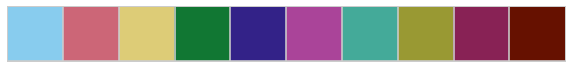

In [7]:
set_pub_plot_context(context="poster")
sns.palplot(sns.color_palette())

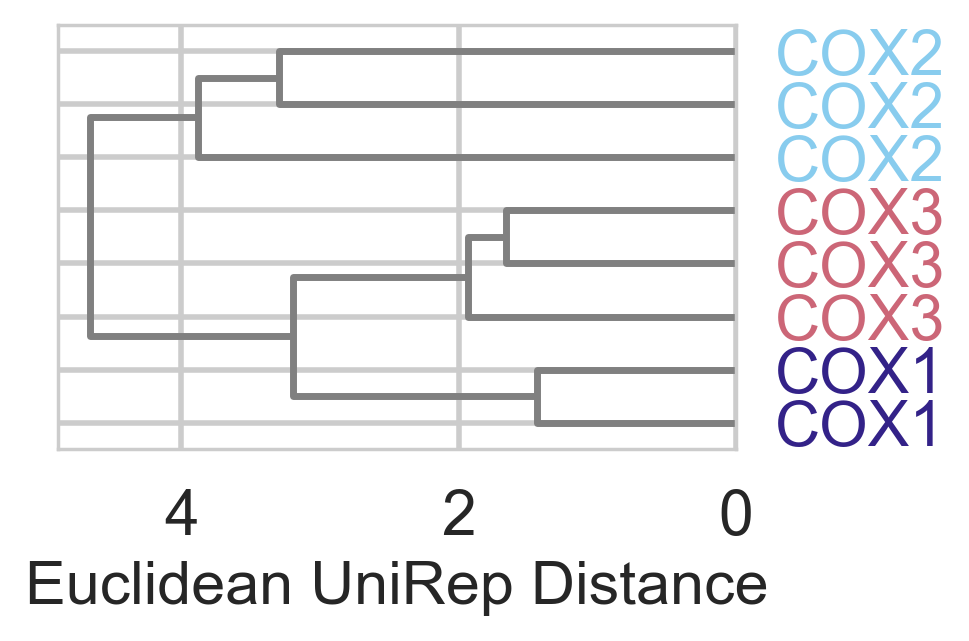

In [8]:
set_pub_plot_context(context="poster")
mpl.rcParams['lines.linewidth'] = 2

fig = plt.figure(figsize=(3.5,2.25), dpi=250)
ax = fig.add_subplot(111,
                    xlabel="Euclidean UniRep Distance")
X = to_cluster['avg_hidden'].values.tolist() #Distance or datapoints
linkage = fc.linkage(X, method="average", metric='euclidean', preserve_input=True)
color = "grey"
hier.dendrogram(linkage, orientation="left", 
                distance_sort=True,
                labels=to_cluster['phenotype'].values, 
                link_color_func=lambda _: color,
               ax=ax);
ax.tick_params(labelsize=18)
palette = sns.color_palette()
colors = ([palette[4]] * 2) + ([palette[1]] * 3) + ([palette[0]] * 3)
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
    
save_for_pub(fig,path="./img/supp3_unirep", dpi=250)


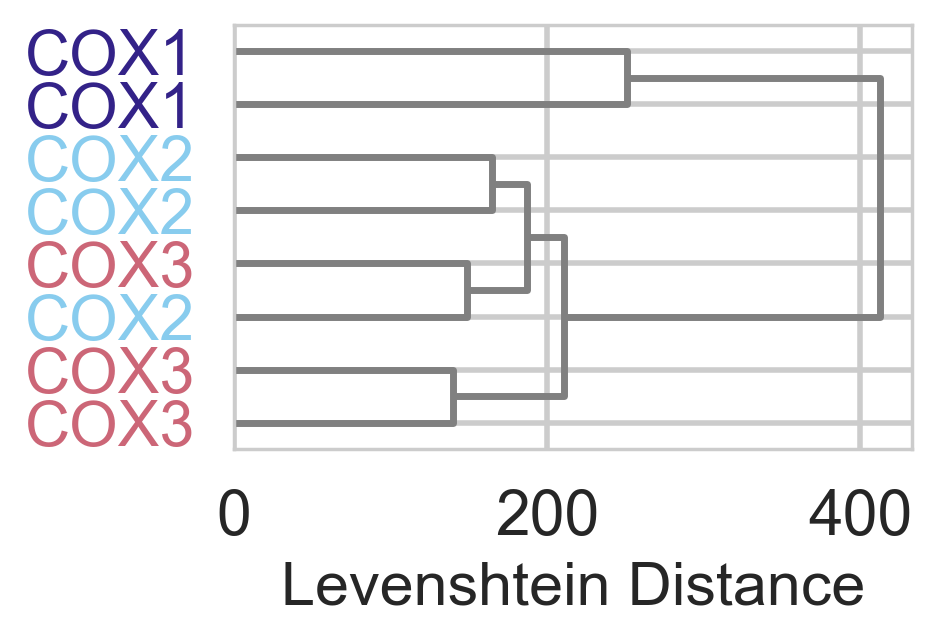

In [9]:
fig = plt.figure(figsize=(3.5,2.25), dpi=250)
ax = fig.add_subplot(111,
                    xlabel="Levenshtein Distance")
X = lev_dist_matrix(to_cluster.sequence.values)[np.triu_indices(len(to_cluster),1)]
linkage = fc.linkage(X, method="average", preserve_input=True)
color = "grey"
hier.dendrogram(linkage, orientation="right", 
                distance_sort=True,
                labels=to_cluster['phenotype'].values,
                link_color_func=lambda _: color);
ax.tick_params(labelsize=18)
palette = sns.color_palette()
colors = (([palette[1]] * 2) + ([palette[0]]) + ([palette[1]]) 
          + ([palette[0]] * 2) 
          + ([palette[4]] * 2)
         )
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)

save_for_pub(fig,path="./img/supp3_unirep", dpi=250)